# Bonus Homework Lecture 3: Bias-Variance Tradeoff

## Preliminaries

### Imports

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.optimize
import sklearn.datasets
from sklearn.linear_model import LinearRegression


%matplotlib inline


### Data Directory

In [2]:
raw_data_dir="../../raw/C50"
data_dir="../../data/C50"

### Random Seed

In [3]:
seed=2506
np.random.seed(seed)

## Bias-Variance Trade-off

### Description of Problem

We will investigate the Bias-Variance decomposition in the learning problem of estimating the function
$$
    f(x) = \begin{cases}
                \max(0,1 - 1.7 x) \,\,\text{  for } x>0 \\
                \max(0,1 + 2 x)  \,\,\text{  for } x<0
            \end{cases}
$$
from data generated by the process
$$
    y = f(x) + \sigma(x) \,\epsilon
$$
where $\epsilon\sim \mathcal{N}(0,1)$ is Gaussian noise.
and
$$
    \sigma(x) = \sigma_0 \sqrt{ 1 - x^2}
$$
with  $\sigma_0=0.05$

In [4]:
sigma0=0.05

In [5]:
def f(x):
    slope=2-0.3*(x>0)
    return  np.maximum(0,1-slope*np.abs(x))

def sigma(x):
    return np.sqrt(1-x*x)*sigma0

### Visualize $f(x)$

<div class="alert alert-block alert-success"> Problem 0.1 </div>
Generate an array `X_test` of 101 uniformly space points in the range [-1,1]

In [6]:
X_test = np.linspace(-1, 1, 101)
X_test

array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
       -0.82, -0.8 , -0.78, -0.76, -0.74, -0.72, -0.7 , -0.68, -0.66,
       -0.64, -0.62, -0.6 , -0.58, -0.56, -0.54, -0.52, -0.5 , -0.48,
       -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34, -0.32, -0.3 ,
       -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16, -0.14, -0.12,
       -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,
        0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,  0.22,  0.24,
        0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,  0.4 ,  0.42,
        0.44,  0.46,  0.48,  0.5 ,  0.52,  0.54,  0.56,  0.58,  0.6 ,
        0.62,  0.64,  0.66,  0.68,  0.7 ,  0.72,  0.74,  0.76,  0.78,
        0.8 ,  0.82,  0.84,  0.86,  0.88,  0.9 ,  0.92,  0.94,  0.96,
        0.98,  1.  ])

<div class="alert alert-block alert-success"> Problem 0.2 </div>
plot the function $f(x)$ in the range [-1,1]


Text(0, 0.5, 'y')

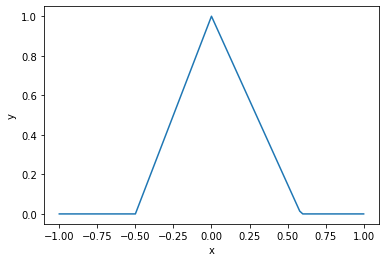

In [7]:
plt.plot(X_test, f(X_test))
plt.xlabel('x')
plt.ylabel('y')

### Generate Sample data

<div class="alert alert-block alert-info"> Problem 1.0 </div>
using `numpy.random.uniform` generate `N`=50 random samples of $X$  in the range (-1,1)

In [8]:
N = np.random.uniform(-1, 1, 50)
N

array([ 0.91880805, -0.92768597,  0.3400076 ,  0.30609054, -0.26085548,
       -0.41336331, -0.25630593,  0.33881448, -0.04504491,  0.47457343,
        0.94057414,  0.478969  ,  0.09621722, -0.8705486 , -0.16318133,
        0.9647926 , -0.23233591,  0.52829664, -0.7224186 , -0.63807704,
       -0.94707565,  0.16145921, -0.57315313,  0.40337585,  0.10096757,
       -0.19230679,  0.68918479,  0.02276916,  0.10431727,  0.40667463,
       -0.66121636, -0.3728888 ,  0.22673528,  0.95066802,  0.55625718,
       -0.1461594 , -0.41365542,  0.77801032,  0.90966558,  0.68459314,
       -0.43179485, -0.06138289,  0.61617381, -0.42439065,  0.3287032 ,
       -0.31203261, -0.4271504 ,  0.19497731,  0.04629639,  0.55834079])

<div class="alert alert-block alert-info"> Problem 1.1 </div>
using `numpy.random.normal` generate N=50 random samples of $Y$  according to the process described in Bias-Variance Trade-off

In [9]:
Y = f(N) + sigma(N)*np.random.normal(0,1,50) # np.random.normal is a Gaussian noise (from distribution nom(0,1))
Y 

array([ 1.41506613e-02, -6.01738943e-03,  4.65354304e-01,  4.60488659e-01,
        5.76897850e-01,  1.37892697e-01,  4.89267256e-01,  3.98681875e-01,
        8.25627239e-01,  1.66021746e-01,  3.31829327e-02,  1.58989040e-01,
        7.65584074e-01,  1.45130509e-04,  6.46492785e-01, -9.22976157e-03,
        4.28960912e-01,  6.15005392e-02,  6.14124200e-02, -6.09800156e-03,
       -4.63784864e-03,  7.00387058e-01, -9.00282258e-02,  2.48510474e-01,
        8.11331473e-01,  5.63431234e-01,  3.90380553e-02,  9.70224306e-01,
        7.47408987e-01,  2.77073878e-01,  3.12339298e-02,  2.10219252e-01,
        6.07119811e-01,  2.94561629e-03,  9.78849899e-02,  7.34068631e-01,
        1.75255276e-01,  7.60072048e-04,  1.67023634e-02, -2.36545755e-02,
        9.42181450e-02,  9.58170005e-01, -3.14446644e-02,  1.92307218e-01,
        4.24346956e-01,  4.28691250e-01,  1.78349925e-01,  7.01496041e-01,
        9.79012377e-01,  1.01395809e-01])

<div class="alert alert-block alert-info"> Problem 1.2 </div>
Plot the random sample of  `X` and `Y` that you generated and the true function on the same graph.

Text(0.5, 1.0, 'Graph of the function f(x) + $\\epsilon$')

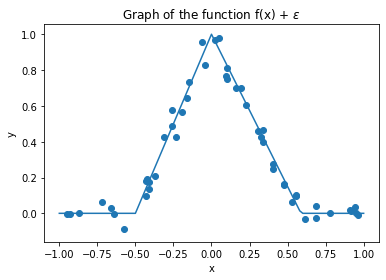

In [10]:
plt.scatter(N, Y, label = 'generated')
plt.plot(X_test, f(X_test), label = 'true function')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Graph of the function f(x) + $\epsilon$')

<div class="alert alert-block alert-info"> Problem 1.3 </div>
Write a python function `generate_sample_Y(N)` that, given an array of inputs X, returns an array `Y` of points generate acording to $f(x)+\sigma(x) \epsilon$

In [11]:
def generate_sample_Y(X):
    Y = f(X) + sigma(X)*np.random.normal(0,1,len(X))
    return Y

<div class="alert alert-block alert-info"> Problem 1.4 </div>
Write a python function `generate_sample(N)` that returns and array `X` of 'N' uniformly distributed ooubts on [-1,1]  and and array `Y` ob  `N` points as per the process above

In [12]:
def generate_sample(N):
    X = np.random.uniform(-1, 1, N)
    Y = generate_sample_Y(X)  # Generate the sample from X
    return X, Y

### Hypothesis Space

Our hypothesis space $\mathcal{H}_K$ will be **symmetric** (even) polynomials $p(x)$ up to degree $K$.

<div class="alert alert-block alert-info"> Problem 2.1 </div>
Write a function `generate_basis(X,K)` that evalue a basis of $\mathcal{H}_K$  of even monomials at an array of given points `X` 

[HINT] You may want to refer to the writen homework for this week.

In [13]:
def generate_basis(X, K):
    Xi = X[:, np.newaxis]
    i = np.arange(0, K+1, 2) # Return evenly spaced value within a given interval
    basis = np.power(Xi, i[np.newaxis, :])
    return basis

<div class="alert alert-block alert-info"> Problem 2.2 </div>
Plot all basis functions up to K=6

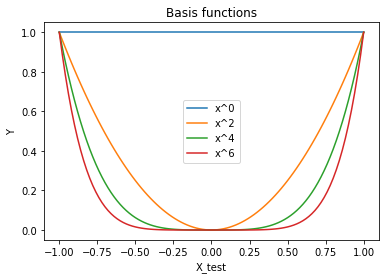

In [14]:
H = generate_basis(X_test, 6)

for K in range(H.shape[1]):
    plt.plot(X_test, H[:, K], label = f'x^{2*K}')
    
plt.xlabel('X_test')
plt.ylabel('Y')
plt.title('Basis functions')
plt.legend() #The simplest legend can be created with the plt.legend() command, which automatically creates a legend for any labeled plot elements: import matplotlib.pyplot as plt plt. style. use('classic') %matplotlib inline import numpy as np.

### Regression Solver

<div class="alert alert-block alert-info"> Problem 3.1 </div>

Fill in the bodies of the `fit` and `predict` functions in the `class` below so that they solve the learning problem for $\hat{h}$ the least square
approximation to $f(x)$ within our hypothesis space $\mathcal{H}$.

[HINT] 

1. You worked the math of this on assignment 2
2. The function `generate_basis`  can be useful
3. You can also look at how a similar problem is solved in the  [`BiasVarianceTradeOff`](.\BiasVarianceTradeOff.ipynb) notebook.

In [15]:
class RegressionSolver:
    def __init__(self,K):
        self.K=K
        self.base_model=LinearRegression(fit_intercept=False)
    def fit(self,X,Y):
        H = generate_basis(X, self.K)
        self.base_model.fit(H, Y)
    def predict(self,X):
        H = generate_basis(X, self.K)
        return self.base_model.predict(H)

<div class="alert alert-block alert-info"> Problem 3.2 </div>

1. fit the `X`, `Y` data you generated before to our model assuming K=10.
2. Plot the predicted values $\hat{h}(x)$ on the points defined by `X_test`

Compare to the true function $f(x)$.

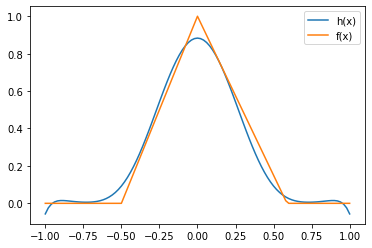

In [16]:
K = 10
model = RegressionSolver(K)
model.fit(N, Y)
h = model.predict(X_test)
plt.plot(X_test, h, label = 'h(x)')
plt.plot(X_test, f(X_test), label = 'f(x)')
plt.legend()

<div class="alert alert-block alert-info"> Problem 3.3 </div>
Compute the *in sample* mean training square error

In [17]:
square_error = np.mean((Y - model.predict(N))**2) # Since computation on the "in sample" dataset
square_error

0.003335541296990926

<div class="alert alert-block alert-info"> Problem 3.4 </div>
Generate 100 new data points and compute the *out of sample* mean test error

In [18]:
X, Y = generate_sample(100)
new_square_error = np.mean((Y - model.predict(X))**2)
new_square_error

0.0035364199482896892

###  Bias-Variance Decomposition

<div class="alert alert-block alert-info"> Problem 4.1 </div>
Using still K=10, N=50

Reserve some space so that you can keep track of the average of $\hat{h}(x)$ and $(\hat{h}(x))^2$ at each point in `X_test`

Using R=1,000 repeats do as follows
1. Generate N random samples of X,Y according to our process specification.
2. Fit model to the data
3. Compute $\hat{h}$ on the uniform grid X_test
4. Accumulate results so that you can later  compute the average of $\hat{h}(x)$  and $(\hat{h}(x))^2$ over each point in `X_test`.
4. Use function `generate_Y`  to generate new  `Y_test` values at each  point in `X_test`.
5. Compute the square error $\left(Y_{test}-\hat{h}(x)\right)^2$ at each point in `X_test`.
6. Accumulate results so that you can compute the average square error averaged  over all the 'R` repeats of the procedure

Using the results of the `R` repeats above
1. Compute the average over the `R` repeats of $\hat{h}$ evaluated at each point in `X_test` 
1. Compute the average over the `R` repeats of $(\hat{h})^2$ evaluated at each pint in `X_test` 
2. Compute the mean square error of `Y_test` over the points `X_test` 

In [35]:
type(X_test)
X_test.shape

(101,)

In [26]:
K=10
N=50

model = RegressionSolver(K)
h_accumulative = np.zeros(len(X_test))
h_sq_accumulative = np.zeros(len(X_test))
sq_accumulative = np.zeros(len(X_test))

for R in range(1001):
    X,Y = generate_sample(N)
    model.fit(X, Y)
    h = model.predict(X_test)
    Y_test = generate_sample_Y(X_test)
    h_accumulative += h
    h_sq_accumulative += h**2
    sq_accumulative += (Y_test - h)**2

h_accumulative /= R
h_sq_accumulative /= R
sq_accumulative /= R 

print(h_accumulative)
print(h_sq_accumulative)
print(sq_accumulative)

[-3.12419426e-02 -1.23149968e-02 -1.79371605e-03  3.20222596e-03
  4.74500008e-03  4.28041182e-03  2.77996122e-03  8.66567224e-04
 -1.08290856e-03 -2.85545211e-03 -4.33735084e-03 -5.46488481e-03
 -6.18804239e-03 -6.44524921e-03 -6.14729016e-03 -5.16878501e-03
 -3.34574768e-03 -4.77919963e-04  3.66528001e-03  9.33621292e-03
  1.67987645e-02  2.63171474e-02  3.81444102e-02  5.25111984e-02
  6.96152175e-02  8.96117563e-02  1.12605550e-01  1.38644184e-01
  1.67713183e-01  1.99732846e-01  2.34556874e-01  2.71972743e-01
  3.11703774e-01  3.53412783e-01  3.96707203e-01  4.41145495e-01
  4.86244695e-01  5.31488897e-01  5.76338466e-01  6.20239787e-01
  6.62635329e-01  7.02973816e-01  7.40720304e-01  7.75365966e-01
  8.06437396e-01  8.33505257e-01  8.56192121e-01  8.74179345e-01
  8.87212879e-01  8.95107887e-01  8.97752106e-01  8.95107887e-01
  8.87212879e-01  8.74179345e-01  8.56192121e-01  8.33505257e-01
  8.06437396e-01  7.75365966e-01  7.40720304e-01  7.02973816e-01
  6.62635329e-01  6.20239

<div class="alert alert-block alert-info"> Problem 4.1 </div>
Plot the average of the prediction $\hat{h}$(x) at the points `X_test`. Compare to the actual function

Text(0.5, 1.0, 'Comparison of the prediction and the actual function')

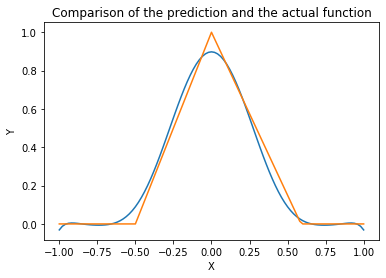

In [27]:
plt.plot(X_test, h_accumulative, label = 'average of the prediction h(x)')
plt.plot(X_test, f(X_test), label = 'actual function')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Comparison of the prediction and the actual function')

<div class="alert alert-block alert-info"> Problem 4.2 </div>
Compute the bias at each point in `X_test`

In [29]:
bias = (f(X_test) - h_accumulative)**2
bias

array([9.76058978e-04, 1.51659146e-04, 3.21741726e-06, 1.02542511e-05,
       2.25150257e-05, 1.83219254e-05, 7.72818441e-06, 7.50938754e-07,
       1.17269094e-06, 8.15360677e-06, 1.88126123e-05, 2.98649660e-05,
       3.82918687e-05, 4.15412373e-05, 3.77891763e-05, 2.67163384e-05,
       1.11940276e-05, 2.28407491e-07, 1.34342775e-05, 8.71648716e-05,
       2.82198489e-04, 6.92592249e-04, 1.45499603e-03, 2.75742596e-03,
       4.84627850e-03, 8.03026687e-03, 5.27156587e-03, 3.43914035e-03,
       2.27654779e-03, 1.57869902e-03, 1.19417751e-03, 1.02225631e-03,
       1.00512926e-03, 1.11641408e-03, 1.34741875e-03, 1.69295176e-03,
       2.13857186e-03, 2.65110652e-03, 3.17402273e-03, 3.62883196e-03,
       3.92318448e-03, 3.96570150e-03, 3.68695530e-03, 3.06539017e-03,
       2.15643172e-03, 1.12260225e-03, 2.62184770e-04, 3.38800276e-05,
       1.07499529e-03, 4.21098628e-03, 1.04546318e-02, 5.02569163e-03,
       2.00588619e-03, 5.67423617e-04, 6.09629807e-05, 1.22868272e-05,
      

<div class="alert alert-block alert-info"> Problem 4.3 </div>
Compute the variance  at each point in `X_test`

In [30]:
variance = h_sq_accumulative - h_accumulative**2 # Using the function V = E**2 - E
variance

array([ 1.21605111e-02,  4.09607308e-03,  1.35317214e-03,  5.10535843e-04,
        2.56812154e-04,  1.66748018e-04,  1.32464966e-04,  1.31206540e-04,
        1.50116531e-04,  1.73660615e-04,  1.88835106e-04,  1.90308358e-04,
        1.80966868e-04,  1.68845314e-04,  1.62836093e-04,  1.69156859e-04,
        1.89574157e-04,  2.21472441e-04,  2.59268163e-04,  2.96429088e-04,
        3.27395716e-04,  3.48905841e-04,  3.60491037e-04,  3.64165340e-04,
        3.63512344e-04,  3.62476297e-04,  3.64177357e-04,  3.70017708e-04,
        3.79248431e-04,  3.89053174e-04,  3.95097091e-04,  3.92405819e-04,
        3.76389699e-04,  3.43816283e-04,  2.93556362e-04,  2.26977470e-04,
        1.47923764e-04,  6.22906733e-05, -2.27337587e-05, -9.96402406e-05,
       -1.61633448e-04, -2.03577059e-04, -2.22711580e-04, -2.19043517e-04,
       -1.95352804e-04, -1.56819490e-04, -1.10323082e-04, -6.35118879e-05,
       -2.37697114e-05,  2.78016928e-06,  1.20998453e-05,  2.78016928e-06,
       -2.37697114e-05, -

<div class="alert alert-block alert-info"> Problem 4.4 </div>
Show that `bias` + `variance` + irreductible error $\sigma^2$ approximately add up to the mean square prediction error for each point in `X_test`

[ 0.00000000e+00 -1.26105900e-05  2.57404849e-06  1.15651829e-05
  1.08934961e-05  2.92859065e-05  6.60263158e-06  4.38107908e-05
  4.77465674e-06  3.37805786e-05 -7.01275439e-06 -5.71116665e-05
 -1.04632867e-04 -2.11427526e-05  2.50670404e-05 -4.41064914e-05
  1.22484488e-05  4.51307695e-05 -1.79524748e-05 -1.12711936e-04
  9.68144564e-05  2.18103144e-06 -1.16120589e-04 -5.35103007e-07
 -2.34236393e-04 -1.21218177e-04  1.89822301e-04 -1.88075491e-04
 -4.04241688e-04 -1.92501391e-04 -2.06116858e-04 -1.13763264e-05
 -3.33732989e-04 -6.97483602e-05 -7.01369164e-05 -2.36930267e-04
 -1.29565738e-04 -3.54075254e-04 -7.30431463e-04 -2.81322013e-04
 -3.44776865e-04 -7.27361532e-05 -3.81372419e-04 -6.02803295e-04
 -8.64371211e-04 -4.39143958e-04 -6.43176119e-04 -9.12692195e-04
 -8.52664260e-04 -1.28282209e-03 -1.18053672e-03 -1.18229360e-03
 -1.20069347e-03 -7.97997694e-04 -7.22215468e-04 -9.62705980e-04
 -9.56996974e-04 -6.16427613e-04 -5.46198272e-04 -6.31759375e-04
 -5.39092220e-04 -3.34625

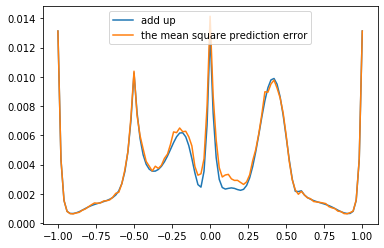

In [43]:
addup = bias + variance + sigma(X_test)**2
print(addup - sq_accumulative)
plt.plot(X_test, addup, label = 'add up')
plt.plot(X_test, sq_accumulative, label = 'the mean square prediction error')
plt.legend()

<div class="alert alert-block alert-info"> Problem 4.5 </div>
In which regions does the bias contribution dominate the prediction error? In which regions does variance  dominate?
In which regions dominates irreducible error?

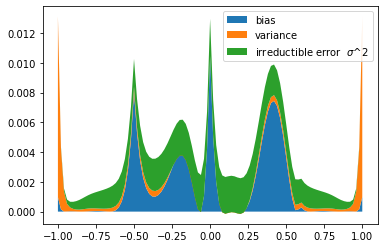

In [50]:
plt.fill_between(X_test, 0, bias, label = 'bias')
plt.fill_between(X_test, bias, bias + variance, label = 'variance')
plt.fill_between(X_test, bias + variance, bias + variance + sigma(X_test)**2 , label = 'irreductible error  $\sigma$^2')
plt.legend()

In [ ]:
# Reading from the plot, we can notice that 
# Bias contributes most in the region: -0.6 ~ -0.4, -0.1 ~ 0.1, 0.3 ~ 0.6
# Variance dominate in the region -0.1 ~ -0.8, 0.8 ~ 1.0
# Irreductible error dominates in the region: around -0.75, 0.3, 0.75

### Bias-Variance Trade-off

<div class="alert alert-block alert-info"> Problem 5.1 </div>
Using still N=50 training sample points, and, averaging over $R=1,000$ repeats find the value of $K$ that has the optimal bias-variance trade-off when averaged over all the points in  `X_test`.

[HINT] Do not need to consider K larger than 14, as variance becomes very large. 

In [58]:
N = 50
Error = []

for K in range(0, 16, 2):
    E = 0
    for R in range (1001):
        X,Y = generate_sample(N)
        model = RegressionSolver(K)
        model.fit(X, Y)
        h = model.predict(X_test)
        Y_test = generate_sample_Y(X_test)
        E += np.mean((Y_test - h)**2) # Getting the mean value
    E /= R
    Error.append(E)
    

0.0036827869996048524


In [63]:
print(np.array(Error).min())
K = range(0, 16, 2)
K[np.array(Error).argmin()]

0.0036827869996048524


8

<div class="alert alert-block alert-info"> Problem 5.3 </div>
In what values  of $K$ does bias dominates, in what region does variance dominate?

In [ ]:
# 

<div class="alert alert-block alert-info"> Problem 5.3 </div>
Can the bias be made arbitrarily close to zero by increasing $K$? Explain your reasoning

In [ ]:
# No, bias could not be eliminated

## Factor Modeling of the US Treasury Yield Curve

<div class="alert alert-block alert-warning"> Warning </div>
This may be a bit harder problem. Feel free to skip it


In [20]:
treasury_data_dir="../../data/finance"

<div class="alert alert-block alert-info"> Problem 6.0 </div>
Load into a panda's DataFrame the  H15 US Treasury data set for the period **1993-2002**
(The file should had been generated by running the `FinancialDataSets` notebook, and it was called `H15_old.csv`.

<div class="alert alert-block alert-info"> Problem 6.1 </div>
1. Separate the dataset into a training set for all dates before 1998-12-31 and a testing set will all dates afterwards


<div class="alert alert-block alert-info"> Problem 6.2 </div>
Compute the daily rate changes for the training and test datasets

## Multi-factor Gaussian model
The G2 Factor model can be generalized to K factors by defining
$$
    \Delta R(T)_t = \sum_{k=1}^K H_k(T) \Delta r_{t,k}
$$
where $\Delta r_{t,k}$ are the $K$ daily changes in interest  rate factors as of date $t$.

The factor loadings for each tenor $T$ are
$$
    H_k(T) = \frac{e^{-\lambda_k T} -1}{\lambda_k T}
$$

<div class="alert alert-block alert-info"> Problem 6.3 </div>
Using as a guide the class  `G2_FactorModel` and the function `errors_30Y_factors` from the `Treasury_CurveModel` notebook fit models with 2,  3  factors to predict the 30Y treasury rate change.

Fit both models to the training data set

<div class="alert alert-block alert-info"> Problem 6.4 </div>
Compute the training and test mean square error of the 2 and 3 factor models

<div class="alert alert-block alert-info"> Problem 6.5 </div>
Does the 2 or 3 factor models has lower training mean squared error? and for the testing data?

<div class="alert alert-block alert-info"> Problem 6.7 </div>
Does difference  betwen the 2 and 3 factor models look significant?